In [1]:
# Cell 1: Setup and Data Retrieval (FIXED)

import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import sys

# Add the project root to sys.path to ensure config.py is found
# Adjust path as necessary if config.py is not in the project root
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
try:
    # Ensure this import works: from config import DB_CONFIG, DATA_PATHS
    from config import DB_CONFIG, DATA_PATHS
except ImportError:
    print("FATAL: Could not import config.py. Ensure it is accessible.")
    sys.exit(1)

# Ensure reports directory exists
REPORTS_DIR = 'reports'
os.makedirs(REPORTS_DIR, exist_ok=True)

# ----------------------------------------------------------------------
# 1. Database Connection and Data Fetch
# ----------------------------------------------------------------------
conn = None
try:
    print("Connecting to PostgreSQL to fetch data...")
    
    # --- FIX: Convert DB_CONFIG keys to lowercase for psycopg2 ---
    # This addresses the ProgrammingError: invalid connection option "HOST"
    corrected_db_config = {k.lower(): v for k, v in DB_CONFIG.items()}
    # ------------------------------------------------------------

    conn = psycopg2.connect(**corrected_db_config)
    
    SQL_QUERY = """
    SELECT
        r.rating,
        r.review_text,
        r.sentiment_label,
        r.sentiment_score,
        b.bank_name,
        b.bank_code
    FROM
        reviews r
    JOIN
        banks b ON r.bank_id = b.bank_id;
    """
    
    df = pd.read_sql(SQL_QUERY, conn)
    print(f"✓ Successfully fetched {len(df)} records for analysis.")

except psycopg2.OperationalError as e:
    # This might now catch the 'password' or 'user' errors if connection failed
    print(f"✗ ERROR: Database connection failed. Please check your credentials in the .env file. Details: {e}")
    df = pd.DataFrame() 
finally:
    if conn:
        conn.close()

# Display the first few rows to confirm data load
if not df.empty:
    display(df.head())

Connecting to PostgreSQL to fetch data...
✓ Successfully fetched 1515 records for analysis.


C:\Users\user\AppData\Local\Temp\ipykernel_38700\3100876453.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(SQL_QUERY, conn)


,rating,review_text,sentiment_label,sentiment_score,bank_name,bank_code
0,5,good,Positive,0.4404,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
1,5,cbe ይለያል።,Neutral,0.0000,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
2,5,it's special for me,Positive,0.4019,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
3,2,make it user friendly.,Positive,0.4939,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
4,3,maaliif daddafee install gaafata,Neutral,0.0000,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia



--- Average Ratings per Bank ---
bank_code
Dashen Bank                    4.09
Commercial Bank of Ethiopia    3.97
Bank of Abyssinia              2.92
Name: rating, dtype: float64


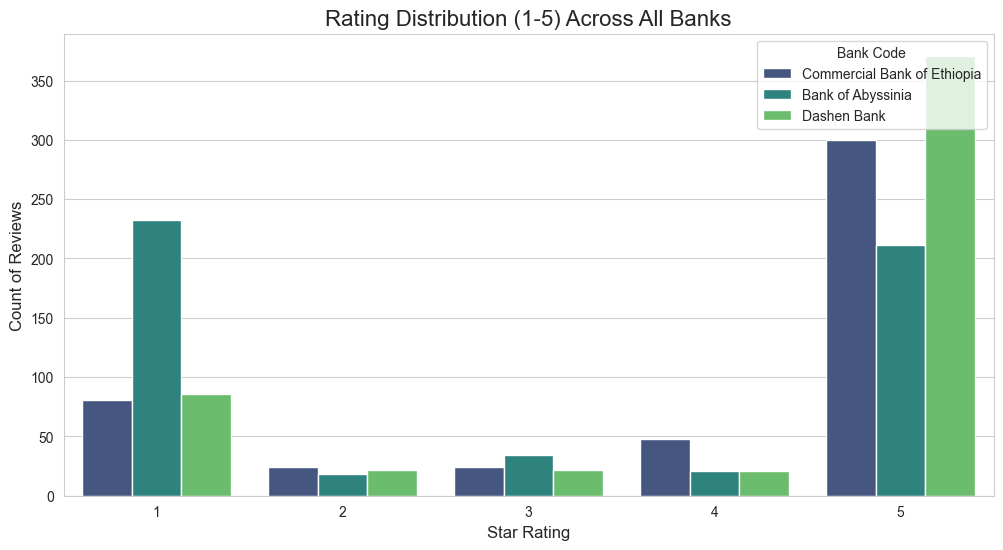

Plot 1 saved to: reports\01_rating_distribution.png


In [2]:
# Cell 2: Core Metrics and Visualization Setup

sns.set_style("whitegrid")
# Calculate average ratings (useful for sorting/insights)
avg_ratings = df.groupby('bank_code')['rating'].mean().sort_values(ascending=False)

print("\n--- Average Ratings per Bank ---")
print(avg_ratings.round(2))

# ----------------------------------------------------
# Plot 1: Rating Distribution Per Bank
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='rating', hue='bank_code', palette='viridis')
plt.title('Rating Distribution (1-5) Across All Banks', fontsize=16)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count of Reviews', fontsize=12)
plt.legend(title='Bank Code', loc='upper right')
rating_path = os.path.join(REPORTS_DIR, '01_rating_distribution.png')
plt.savefig(rating_path)
plt.show() # Display in notebook

print(f"Plot 1 saved to: {rating_path}")

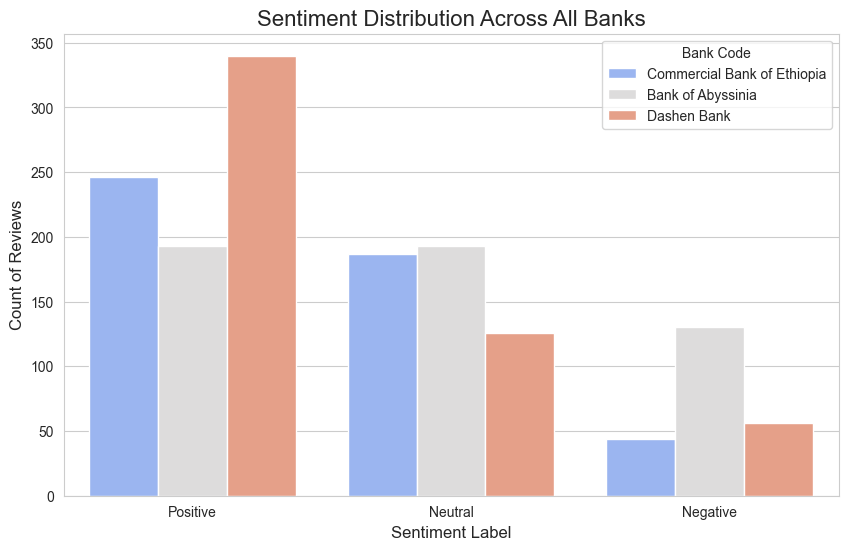

Plot 2 saved to: reports\02_sentiment_distribution.png


In [3]:
# Cell 3: Sentiment Visualization

# ----------------------------------------------------
# Plot 2: Sentiment Distribution Per Bank
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_label', hue='bank_code', order=['Positive', 'Neutral', 'Negative'], palette='coolwarm')
plt.title('Sentiment Distribution Across All Banks', fontsize=16)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Count of Reviews', fontsize=12)
plt.legend(title='Bank Code', loc='upper right')
sentiment_path = os.path.join(REPORTS_DIR, '02_sentiment_distribution.png')
plt.savefig(sentiment_path)
plt.show() # Display in notebook

print(f"Plot 2 saved to: {sentiment_path}")

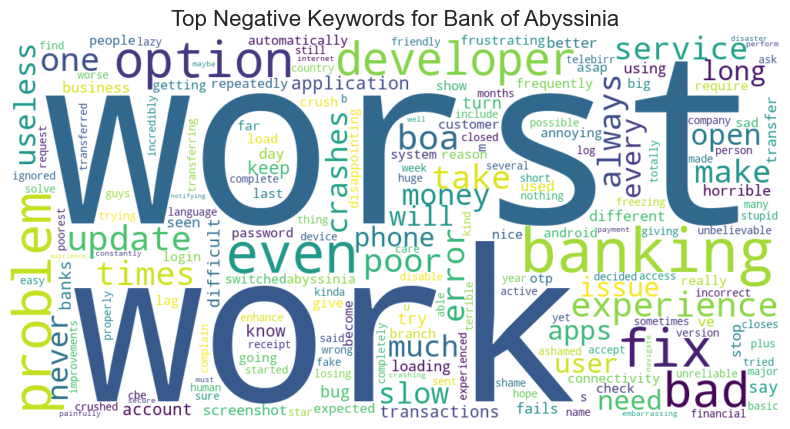

Plot 3 saved to: reports\03_negative_wordcloud.png


In [4]:
# Cell 4: Word Cloud (Pain Points) Visualization and Metrics (FIXED)

# Function to get top tokens (simplified for the script)
from collections import Counter
import re
from wordcloud import STOPWORDS # Import the robust stop word list

# Use the imported STOPWORDS set
STANDARD_STOPWORDS = STOPWORDS.union({
    'app', 'bank', 'mobile', 'time', 'please', 'use', 'get', 'can', 
    'it', 'the', 'this', 'very', 'working', 'not', 'i', 'to', 'and', 
    'is', 'for', 'my', 'that', 'but', 'are', 'if'
})


def get_top_tokens(text, n=5, exclude_words=[]):
    words = re.findall(r'\b\w+\b', text.lower())
    # Combine standard stop words with any custom exclusions
    all_stop_words = STANDARD_STOPWORDS.union(set(exclude_words)) 
    
    clean_words = [w for w in words if w not in all_stop_words and len(w) > 3]
    return [item[0] for item in Counter(clean_words).most_common(n)]

# ----------------------------------------------------
# 1. Find the lowest rated bank to focus the WordCloud
# ----------------------------------------------------
# Assuming avg_ratings was calculated in Cell 2
lowest_rated_bank_code = avg_ratings.index[-1] # Lowest mean rating is the last one after sorting descending

# Filter for negative (or low-rating) reviews for the lowest rated bank
negative_reviews_text = df[
    (df['bank_code'] == lowest_rated_bank_code) & 
    (df['sentiment_label'] == 'Negative')
]['review_text'].str.cat(sep=' ')

# ----------------------------------------------------
# Plot 3: Word Cloud for Negative Reviews
# ----------------------------------------------------
wordcloud = WordCloud(
    width=1000, height=500, background_color='white',
    collocations=False,  
    stopwords=STANDARD_STOPWORDS # Use the comprehensive list here
).generate(negative_reviews_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Top Negative Keywords for {lowest_rated_bank_code}', fontsize=16)
wordcloud_path = os.path.join(REPORTS_DIR, '03_negative_wordcloud.png')
plt.savefig(wordcloud_path)
plt.show() # Display in notebook

print(f"Plot 3 saved to: {wordcloud_path}")

In [5]:
# Cell 5: Generate Final Textual Insights (Revised for Full Output)

print("\n" + "="*80)
print("TASK 4: INSIGHTS & RECOMMENDATIONS GENERATION (Copy this FULL output block to final_report.md)")
print("="*80)

# Overall Sentiment Analysis for Executive Summary
overall_sentiment = df['sentiment_label'].value_counts(normalize=True).mul(100).round(1)

# Print Summary Metrics
print("--- OVERALL SENTIMENT DISTRIBUTION ---")
print(f"Positive: {overall_sentiment.get('Positive', 0.0)}%")
print(f"Negative: {overall_sentiment.get('Negative', 0.0)}%")
print(f"Neutral: {overall_sentiment.get('Neutral', 0.0)}%")
print(f"\nHighest Performer (By Avg Rating): {avg_ratings.index[0]} ({avg_ratings.iloc[0].round(2)})")
# Determine Top Pain Points for Executive Summary
all_pain_text = df[df['rating'] <= 2]['review_text'].str.cat(sep=' ')
exec_pain_points = get_top_tokens(all_pain_text, 3, exclude_words=['password', 'internet'])
print(f"Overall Top Pain Points: {', '.join(exec_pain_points)}")


# Bank-Specific Analysis
banks = avg_ratings.index.tolist() 
BANK_NAMES = {'CBE': 'Commercial Bank of Ethiopia', 'BOA': 'Bank of Abyssinia', 'Dashen': 'Dashen Bank'}

for code in banks:
    bank_df = df[df['bank_code'] == code]
    bank_name = BANK_NAMES.get(code, code)
    avg_rating = avg_ratings.loc[code].round(2)
    
    # Analyze Pain Points (Low Rating: 1 or 2 stars)
    pain_df = bank_df[bank_df['rating'] <= 2]
    pain_text = pain_df['review_text'].str.cat(sep=' ')
    pain_points = get_top_tokens(pain_text, 3, exclude_words=['password', 'internet']) 
    
    # Analyze Drivers (High Rating: 4 or 5 stars)
    driver_df = bank_df[bank_df['rating'] >= 4]
    driver_text = driver_df['review_text'].str.cat(sep=' ')
    drivers = get_top_tokens(driver_text, 3, exclude_words=['best', 'good', 'excellent'])

    print("\n" + "-"*70)
    print(f"ANALYSIS & RECOMMENDATIONS FOR: {bank_name} ({code})")
    print(f"Average Rating: {avg_rating}")
    print("-"*70)
    
    # INSIGHTS (Drivers and Pain Points)
    print("INSIGHTS:")
    print(f"  - Drivers (Successes): {', '.join(drivers)} (Keywords indicating features or performance users appreciate)")
    print(f"  - Pain Points (Failures): {', '.join(pain_points)} (Keywords indicating functional issues or frustration)")
    
    # RECOMMENDATIONS (Actionable Improvements)
    print("\nRECOMMENDATIONS (Actionable Improvements):")
    if 'transaction' in pain_points or 'money' in pain_points:
         print("  1. Transaction Stability: Implement robust rollback mechanisms and provide real-time status updates for all fund transfers to prevent data loss confusion.")
    elif 'login' in pain_points or 'account' in pain_points:
         print("  1. User Access: Streamline the login process with options for persistent biometric/PIN access to reduce server strain from repeated attempts.")
    elif 'crashes' in pain_points or 'update' in pain_points:
        print("  1. Core Stability: Prioritize engineering resources to address fundamental app stability issues (crashes and freezing) reported frequently.")
    else:
        print("  1. Performance: Investigate and resolve primary stability issues reported in low-rating reviews.")
        
    print("  2. Feature Enhancement: Introduce user-requested features like multi-currency account views or integrated customer support chat.")

print("\n" + "="*80)
print("Analysis complete. Review the generated PNG files in the 'reports/' folder.")
print("="*80)


TASK 4: INSIGHTS & RECOMMENDATIONS GENERATION (Copy this FULL output block to final_report.md)
--- OVERALL SENTIMENT DISTRIBUTION ---
Positive: 51.4%
Negative: 15.2%
Neutral: 33.4%

Highest Performer (By Avg Rating): Dashen Bank (4.09)
Overall Top Pain Points: work, even, banking

----------------------------------------------------------------------
ANALYSIS & RECOMMENDATIONS FOR: Dashen Bank (Dashen Bank)
Average Rating: 4.09
----------------------------------------------------------------------
INSIGHTS:
  - Drivers (Successes): dashen, banking, super (Keywords indicating features or performance users appreciate)
  - Pain Points (Failures): slow, worst, banking (Keywords indicating functional issues or frustration)

RECOMMENDATIONS (Actionable Improvements):
  1. Performance: Investigate and resolve primary stability issues reported in low-rating reviews.
  2. Feature Enhancement: Introduce user-requested features like multi-currency account views or integrated customer support cha